# Tweets

In [1]:
import sys
sys.path.append('/Users/efraflores/Desktop/hub/diplo/venv/lib/python3.9/site-packages')

## Import

In [2]:
import os

BASE_DIR = '/Users/efraflores/Desktop/EF/Diplo/data/05'
FILE_NAME = '0505_tuit.csv'
print(os.listdir(BASE_DIR))

['0501_cred.json', '0503_fraud.csv', 'tuit_model_supervised.pickle', '0505_profiles.csv', '.DS_Store', '0505_clusters.csv', 'tad_continous.csv', '0503_trans.csv', '0505_tuit.csv', 'ufo_discrete_model.pkl', '0503_holder.csv', 'ufo_continous_model.pkl', '0503_tad.csv', '0503_Xclustering.csv', '0503_city.csv', '0501_untitled.csv', 'tad_discrete.csv', 'tuit_model_unsupervised.pickle', 'ufo_sentim.csv', '0502_ufo_data.csv', '0505']


In [3]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

df = pd.read_csv(os.path.join(BASE_DIR,FILE_NAME),encoding='latin').set_index('tweet_id')
print(df.info())
df.sample()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132707 entries, 1027179935184703489 to 1025806323844300800
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   tweet_date_created  132707 non-null  object
 1   tweet_text          132707 non-null  object
 2   language            132707 non-null  object
 3   sentiment           132707 non-null  object
 4   sentiment_score     132707 non-null  object
dtypes: object(5)
memory usage: 6.1+ MB
None


,tweet_date_created,tweet_text,language,sentiment,sentiment_score
tweet_id,,,,,
1028013921159053319,2018-08-10T20:23:13.319000,DIRECTO: Se va Rashford y entra Lukaku. Cambio...,es,NEUTRAL,"{""Neutral"":0.745965898036956787109375,""Negativ..."


## Functions

### Timing and tone

In [4]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

### Clean tweet

In [5]:
'''!pip install bs4'''
import re, unicodedata

def clean_tweet(text):
    # Obtenemos el texto:
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    text = re.sub("[^a-zA-Z'\s0-9]",' ',text.decode('utf-8'),flags=re.UNICODE)
    # Eliminación de las menciones en los tweets. Se excluyen los @ junto con todos los caracteres que le siguen (De la A a la Z, en minúsculas y mayusculas, y números del 0 al 9)
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    # Eliminación de las menciones en los tweets. Se excluyen los # junto con todos los caracteres que le siguen (De la A a la Z, en minúsculas y mayusculas, y números del 0 al 9)
    text = re.sub(r"#[A-Za-z0-9]+", ' ', text)
    # Eliminación de los links que inicien con https o http. Inicamos que la s es opcional (s?).
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    # Eliminación de los links que inicien con www.
    text = re.sub(r"www.[A-Za-z0-9./]+", ' ', text)
    # Eliminación de todos los catacteres menos las letras y signos de puntuación. 
    text = re.sub(r"[^a-zA-Z]", ' ', text)
    #Elimina caracteres múltiples
    text = re.sub(r'(\S)\1*',r'\1',text)
    # Eliminamos espacios en blanco dobles.
    text = re.sub(r" +", ' ', text)
    return text.lower()

### K-clusters

In [6]:

'''!pip install pygal'''
import pygal
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

def koptimo(df):
    sse,db,slc = {}, {}, {}
    for k in range(2, 16):
        kmeans = KMeans(n_clusters = k, max_iter= 100, random_state = 22).fit(df)
        if k == 3: labels = kmeans.labels_
        clusters = kmeans.labels_
        sse[k] = kmeans.inertia_ 
        db[k] = davies_bouldin_score(df, clusters)
        slc[k] = silhouette_score(df, clusters)

    dicts = [sse,db,slc]

    for dicc in dicts:
        min_value = min(list(dicc.values()))
        max_value = max(list(dicc.values()))
        for k in dicc.keys():
            dicc[k] = (dicc[k] - min_value + 1)/(max_value - min_value + 1)

    line_chart = pygal.Line()
    line_chart.title = 'K-óptimo'
    line_chart.x_labels = map(str, sse.keys())
    for name, dicc in zip(['Inertia','DB','Silhouette'],dicts):
        line_chart.add(name, list(map(lambda x: round(x,2), dicc.values())))
    display(line_chart)
    return line_chart

### Clustering

In [7]:
'''!pip install seaborn'''
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

def clustering(df,
               cols,
               n_clusters=5,
               kmeans=False):
    df = df.copy()
    mm_df = MinMaxScaler()
    Xs = pd.DataFrame(mm_df.fit_transform(df[cols]), 
                      index = df.index,
                      columns = cols)
    
    cluster = (KMeans(n_clusters, random_state=22) if kmeans 
               else GaussianMixture(n_clusters, random_state=22))
    Xs['cluster'] = cluster.fit_predict(Xs)
    
    dict_cluster = dict(enumerate(string.ascii_uppercase[:n_clusters]))
    df['cluster'] = Xs['cluster'].map(dict_cluster) 
    print(f'Distribución de registros en los {n_clusters} clústeres')
    display(df['cluster'].value_counts(1).reset_index().sort_values(by='index'))

    pca = PCA(2)
    pipe_pca = Pipeline(steps=[('MinMax', mm_df),('PCA', pca)])
    Xg = pd.DataFrame(pipe_pca.fit_transform(df.iloc[:,:-1]), 
                      index = df.index,
                      columns = ['p1','p2'])
    Xg['cluster'] = df['cluster'].copy()
    print(f'Varianza explicada con 2dim: {"{:.1%}".format(pca.explained_variance_ratio_.sum())}')
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=Xg.sort_values(by='cluster'),
                    x='p1',
                    y='p2',
                    alpha=0.5,
                    hue='cluster', 
                    palette = 'Paired')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show();
    
    return df,cluster

### Profiles

In [8]:
def profiles(df,cols=None,cluster='cluster'):
    n_clusters = len(set(df[cluster]))
    
    if cols==None:
        cols=df.columns
        aux = df[cols].groupby(cluster).mean()
        #aux = aux.transpose()
        for col in aux.columns:
            aux[col] /= aux[col].sum()

        fig = plt.figure()
        fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(aux.columns)/3))))
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.9)
        sns.heatmap(aux.transpose(),cmap='Blues')
        plt.show();
        
    else:
        for col in cols:
            aux = df.copy()
            aux['n'] = 1
            aux = aux.pivot_table(index=cluster,
                                  columns=col,
                                  values='n',
                                  aggfunc='count',
                                  fill_value=0)
            for columna in aux.columns:
                aux[columna] /= aux[columna].sum()

            fig = plt.figure()
            fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(set(df[col]))/4))))
            fig.patch.set_facecolor('white')
            fig.patch.set_alpha(0.9)
            sns.heatmap(aux.transpose(), cmap = 'Blues')
            plt.show();

## Transform

### Outliers

In [9]:
#There are outliers in the title length
df['len'] = df['tweet_text'].str.split().str.len()
df['len'].describe([i/10 for i in range(0,10,2)]+[.05,.95])

count   132707.0000
mean        23.1615
std         11.2318
min          1.0000
0%           1.0000
5%           9.0000
20%         13.0000
40%         18.0000
50%         20.0000
60%         24.0000
80%         33.0000
95%         45.0000
max         94.0000
Name: len, dtype: float64

In [10]:
import numpy as np

df = df[(df['len'] < np.percentile(df['len'],98))& 
        (df['len'] > np.percentile(df['len'],2))].copy()
df['len'].describe([i/10 for i in range(0,10,2)])

count   125664.0000
mean        23.0198
std         10.1775
min          9.0000
0%           9.0000
20%         14.0000
40%         18.0000
50%         21.0000
60%         24.0000
80%         32.0000
max         49.0000
Name: len, dtype: float64

### Clean tweet

In [11]:
df['clean_tweet'] = df['tweet_text'].apply(clean_tweet)
df.sample(2)

,tweet_date_created,tweet_text,language,sentiment,sentiment_score,len,clean_tweet
tweet_id,,,,,,,
1037389753778237440,2018-09-05T17:19:25.440000,@Alcacer_Gomes @LFC En 2 semanas nos van a vio...,es,NEUTRAL,"{""Neutral"":0.869675099849700927734375,""Negativ...",16,alcacer gomes lfc en semanas nos van a violar...
1027774073676472320,2018-08-10T04:30:08.320000,#LaMásCompartida: Carlos Sánchez vuelve a la P...,es,NEUTRAL,"{""Neutral"":0.95131790637969970703125,""Negative...",15,lamascompartida carlos sanchez vuelve a la pr...


In [12]:
df.loc[1035912630307835910,:]

tweet_date_created                           2018-09-01T15:29:52.910000
tweet_text            #LigaPremierTD Al 71´Gooooooool del @ChelseaFC...
language                                                             es
sentiment                                                       NEUTRAL
sentiment_score       {"Neutral":0.95787942409515380859375,"Negative...
len                                                                  15
clean_tweet            ligapremiertd al gol del chelseafc aparecio p...
Name: 1035912630307835910, dtype: object

### Variables

In [13]:
#All hashtags or mentions
df['#_or_@'] = df['tweet_text'].apply(lambda x: ' '.join(re.findall(r'[@|#]([\S]+)',x)))
#Split them like "VamosAmerica" to "vamos america", "UFC" stands the same
df['#_or_@'] = df['#_or_@'].apply(lambda x:re.sub(r'([A-Z])(?![A-Z])',lambda a:' '+a.group(1).lower(),x).strip())

df['length'] = df['tweet_text'].apply(len)
df['relevance'] = df['clean_tweet'].apply(len)/(df['length']+1e-10)

df['n_mentions'] = df['tweet_text'].apply(lambda x: len(re.findall('@',x)))
df['n_hashtags'] = df['tweet_text'].apply(lambda x: len(re.findall('#',x)))
df['n_links'] = df['tweet_text'].apply(lambda x: len(re.findall('http',x)))
df['n_uppercase'] = df['tweet_text'].apply(lambda x: len(re.findall('[A-Z]',x)))

df['p_mentions'] = df['n_mentions'] / df['len']
df['p_hashtags'] = df['n_hashtags'] / df['len']
df['p_links'] = df['n_links'] / df['len']
df['p_uppercase'] = df['n_uppercase'] /df['length']

df['n_len_p_word'] = df['length'] / df['len']
df['lpw_clean'] = df['clean_tweet'].apply(len) / df['len']

df['tot_text'] = df['#_or_@']+" "+df['clean_tweet']

backup = df.copy()
df.sample()

,tweet_date_created,tweet_text,language,sentiment,sentiment_score,len,clean_tweet,#_or_@,length,relevance,...,n_hashtags,n_links,n_uppercase,p_mentions,p_hashtags,p_links,p_uppercase,n_len_p_word,lpw_clean,tot_text
tweet_id,,,,,,,,,,,,,,,,,,,,,
1025366955157606400,2018-08-03T13:05:07.400000,En 8? días regresa la @premierleague para noso...,es,NEUTRAL,"{""Neutral"":0.67523658275604248046875,""Negative...",13,en dias regresa la premierleague para nosotros...,premierleague COY s,98,0.8571,...,1,1,16,0.0769,0.0769,0.0769,0.1633,7.5385,6.4615,premierleague COY s en dias regresa la premier...


In [14]:
num = df.head().describe().columns.tolist()
X = df.reset_index().set_index(['tweet_id','tot_text'])[num].copy()
X = X.reset_index().set_index('tweet_id').copy()
X.sample()

,tot_text,len,length,relevance,n_mentions,n_hashtags,n_links,n_uppercase,p_mentions,p_hashtags,p_links,p_uppercase,n_len_p_word,lpw_clean
tweet_id,,,,,,,,,,,,,,
1036275484777164800,e_FLEISCHMA n watfordF c spurs official e f...,9,70,0.8571,3,0,0,17,0.3333,0.0000,0.0000,0.2429,7.7778,6.6667


In [15]:
X.columns

Index(['tot_text', 'len', 'length', 'relevance', 'n_mentions', 'n_hashtags',
       'n_links', 'n_uppercase', 'p_mentions', 'p_hashtags', 'p_links',
       'p_uppercase', 'n_len_p_word', 'lpw_clean'],
      dtype='object')

## Supervised

### Preprocessing

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,df['sentiment'].values,
                                                    train_size=0.77,
                                                    random_state=22)
print(X_test.shape)

(28903, 14)


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

mm_x = MinMaxScaler()

tv = TfidfVectorizer(ngram_range=(1,1), 
                     min_df=1, 
                     max_features=10000)

prep = ColumnTransformer(transformers=[
    ('Scale', mm_x, num),
    ('CountV', tv, 'tot_text')
])

### LogReg

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=-1)
model_logreg = Pipeline(steps=[('preproc', prep),
                               ('model', logreg)])

model_logreg.fit(X_train,y_train).score(X_test,y_test)

0.8978306750164343

In [19]:
print(model_logreg.score(X_train,y_train))

0.9119996692882463


### RandomForest

from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_jobs=-1)

param_forest = {'n_estimators': [x for x in range(1400, 1500, 30)],
                'max_features': ['auto', 'sqrt', 'log2'],
                'criterion': ['gini', 'entropy'],
                'class_weight': ['balanced', None],
                'min_samples_split': [x for x in range(10, 22,3)],
                'min_samples_leaf': [x/100 for x in range(1, 6,2)]
               }

from sklearn.model_selection import RandomizedSearchCV
search_forest = RandomizedSearchCV(param_distributions = param_forest, 
                                   cv = 4, 
                                   n_jobs = -1, 
                                   scoring = 'accuracy',
                                   estimator = forest,
                                   verbose = 5,
                                   n_iter = 30,
                                   random_state = 22)

model_forest = Pipeline(steps=[('preproc', prep),
                               ('model', search_forest)])

model_forest.fit(X_train,y_train).score(X_test,y_test)

### Confussion Matrix

In [20]:
from sklearn.metrics import confusion_matrix
model = model_logreg
pd.DataFrame(confusion_matrix(y_test,model.predict(X_test))).style.background_gradient(cmap='Blues')

,0,1,2,3
0,18,45,46,39
1,5,913,1017,73
2,6,247,23881,288
3,12,75,1100,1138


### Save supervised

In [21]:
import pickle
with open(os.path.join(BASE_DIR,'tuit_model_supervised.pickle'), 'wb') as f:
    pickle.dump(model, f)

## Unsupervised

In [22]:
df = df.join(pd.DataFrame(df['sentiment_score'].apply(eval).tolist(),index=df.index))
df.sample(2)

,tweet_date_created,tweet_text,language,sentiment,sentiment_score,len,clean_tweet,#_or_@,length,relevance,...,p_hashtags,p_links,p_uppercase,n_len_p_word,lpw_clean,tot_text,Neutral,Negative,Positive,Mixed
tweet_id,,,,,,,,,,,,,,,,,,,,,
1034931115126079489,2018-08-29T22:29:40.489000,? Real Madrid ?\n\n#marcelo #psg #mbappe #emir...,es,NEUTRAL,"{""Neutral"":0.995412051677703857421875,""Negativ...",34,real madrid marcelo psg mbape emirates campio...,marcelo psg mbappe emirates campionsleague liv...,301,0.7143,...,0.8529,0.0294,0.0565,8.8529,6.3235,marcelo psg mbappe emirates campionsleague liv...,0.9954,0.0007,0.0032,0.0007
991758824930410503,2018-05-02T19:18:24,@diarioas @LFC @ASRomaEspanol La roma que se c...,es,NEGATIVE,"{""Neutral"":0.02429048530757427215576171875,""Ne...",46,diarioas lfc asromaespanol la roma que se cre...,diarioas LF c AS roma espanol,244,0.9754,...,0.0000,0.0000,0.0328,5.3043,5.1739,diarioas LF c AS roma espanol diarioas lfc as...,0.0243,0.9478,0.0057,0.0222


### K-clusters

In [23]:
X_unsup = df[df.head().describe().columns].copy()
print(X_unsup.columns.tolist())
X_unsup.sample()

['len', 'length', 'relevance', 'n_mentions', 'n_hashtags', 'n_links', 'n_uppercase', 'p_mentions', 'p_hashtags', 'p_links', 'p_uppercase', 'n_len_p_word', 'lpw_clean', 'Neutral', 'Negative', 'Positive', 'Mixed']


,len,length,relevance,n_mentions,n_hashtags,n_links,n_uppercase,p_mentions,p_hashtags,p_links,p_uppercase,n_len_p_word,lpw_clean,Neutral,Negative,Positive,Mixed
tweet_id,,,,,,,,,,,,,,,,,
1035852323426369537,11,100,0.8500,0,3,1,11,0.0000,0.2727,0.0909,0.1100,9.0909,7.7273,0.9277,0.0543,0.0116,0.0064


ModuleNotFoundError: No module named 'cairosvg'

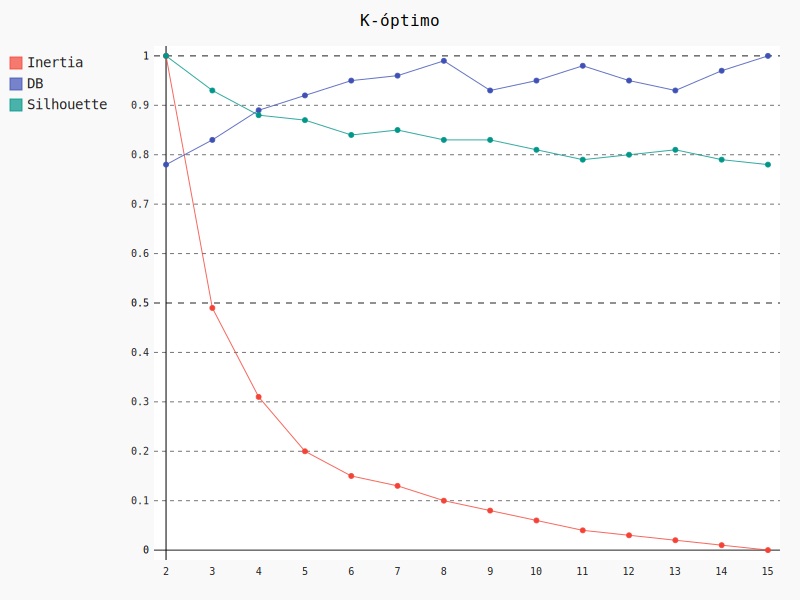

In [24]:
line_chart = koptimo(X_unsup.sample(frac=.01))

In [25]:
line_chart.render_in_browser()

file:///var/folders/j4/1p33_bh96yn8pdz3b_5t80hm0000gn/T/tmp6idxdmm4.html


### Clustering

Distribución de registros en los 4 clústeres


,index,cluster
1,A,0.2682
0,B,0.5011
2,C,0.1248
3,D,0.1059


Varianza explicada con 2dim: 61.9%


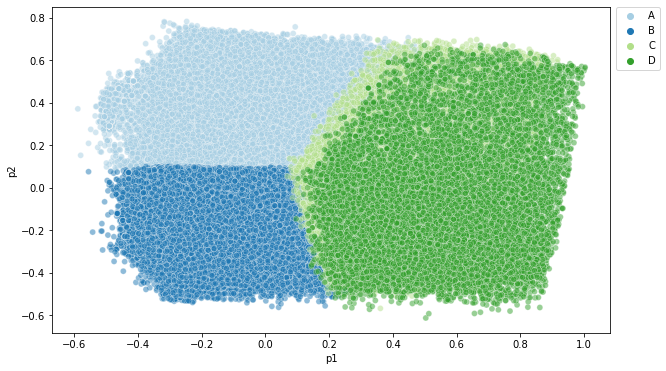

In [26]:
X_cluster,cluster_model = clustering(X_unsup,X_unsup.columns,n_clusters=4,kmeans=True)

In [27]:
cluster_model = KMeans(4, random_state=22)
cluster_model.fit(X_unsup)
cluster_model.predict(X_unsup.sample(100))

array([3, 0, 3, 0, 0, 0, 1, 3, 3, 2, 2, 1, 0, 3, 0, 3, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 1, 2, 1, 3, 3, 1, 3, 0, 0, 0, 3, 3, 1, 2, 0, 2, 0, 1, 0,
       1, 2, 3, 3, 0, 3, 3, 0, 1, 3, 3, 0, 0, 1, 0, 1, 0, 1, 3, 2, 3, 0,
       3, 3, 1, 0, 3, 0, 0, 0, 2, 1, 2, 3, 3, 2, 1, 0, 2, 3, 2, 3, 1, 2,
       2, 0, 3, 2, 1, 2, 3, 0, 0, 0, 0, 2], dtype=int32)

### Profiles

In [28]:
X_cluster.groupby("cluster").mean().style.background_gradient(cmap='Blues')

,len,length,relevance,n_mentions,n_hashtags,n_links,n_uppercase,p_mentions,p_hashtags,p_links,p_uppercase,n_len_p_word,lpw_clean,Neutral,Negative,Positive,Mixed
cluster,,,,,,,,,,,,,,,,,
A,34.515667,234.459646,0.890339,1.934188,3.723043,0.746988,23.356477,0.056223,0.119348,0.022966,0.099011,6.888306,6.114625,0.854529,0.050059,0.073318,0.022094
B,16.352057,120.884151,0.894797,2.106654,1.352771,0.572654,13.890456,0.141220,0.085603,0.036013,0.114969,7.529897,6.716771,0.832086,0.063467,0.086669,0.017778
C,25.030545,154.277834,0.937375,2.298814,0.660694,0.167581,11.507780,0.106281,0.027208,0.007339,0.079622,6.260149,5.857862,0.328567,0.469396,0.094034,0.108002
D,23.087829,149.003681,0.926062,1.998197,0.934560,0.299023,12.138768,0.104611,0.042532,0.014236,0.085786,6.622465,6.116519,0.290483,0.048722,0.599072,0.061722


<Figure size 432x288 with 0 Axes>

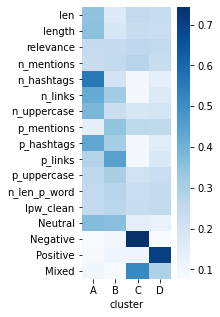

In [29]:
profiles(X_cluster)

### Export

In [30]:
X_cluster.groupby("cluster").mean().to_csv(os.path.join(BASE_DIR,'0505_profiles.csv'))
X_cluster.to_csv(os.path.join(BASE_DIR,'0505_clusters.csv'))

In [31]:
import pickle

with open(os.path.join(BASE_DIR,'tuit_model_unsupervised.pickle'), 'wb') as f:
    pickle.dump(cluster_model, f)

## End

In [32]:
time_exp(time.time()-start)
tone()

1 minutos con 17.76 segundos
